# SWAT Time Series RNN

The National Centers for Environmental Information (NCEI) provides public access to environmental data archives. The data set **DURHAM** contains hourly weather information for the city of Durham, North Carolina from 2008 to 2017, approximately 90,000 observations. The goal is to use a recurrent neural network to forecast the maximum hourly temperature in Durham, North Carolina.  

| Name       | Model Role | Measurement Level | Description                                                            |
|:-----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| LST_DATE   | Date       | Date              | Date of each observation in YYYYMMDD format                            |
| LST_TIME   | Input      | Nominal           | Hour of the observation (0-2300 by 100)                                |
| T_MAX      | Target     | Interval          | Maximum air temperature in degrees C during the hour                   |
| P_CALC     | Input      | Interval          | Total amount of percipitation in mm during the hour                    |

# Load Packages

In [1]:
import swat
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
swat.options.cas.print_messages = True

# Connect to CAS

In [2]:
conn = swat.CAS("server", 30571, "student", "Metadata0")

# Load Data onto the Server

In [3]:
castbl = conn.read_csv("D:/Workshop/Winsas/VOSI/durham.csv", casout = dict(name="durham", replace=True))
indata = 'durham'

NOTE: Cloud Analytic Services made the uploaded file available as table DURHAM in caslib CASUSER(student).
NOTE: The table DURHAM has been created in caslib CASUSER(student) from binary data uploaded to Cloud Analytic Services.


In [4]:
display(castbl.shape)
castbl.head()

(87672, 4)

,LST_DATE,LST_TIME,T_MAX,P_CALC
0,20161231.0,2000.0,7.3,0.0
1,20161231.0,2100.0,7.2,0.0
2,20161231.0,2200.0,6.7,0.0
3,20161231.0,2300.0,7.0,0.0
4,20170101.0,0.0,7.2,0.0


# Plot the Time Series

In [5]:
conn.loadActionSet('dataStep')
actions = conn.builtins.help(actionSet='dataStep')

NOTE: Added action set 'dataStep'.
NOTE: Information for action set 'dataStep':
NOTE:    dataStep
NOTE:       runCodeTable - Runs DATA step code stored in a CAS table
NOTE:       runCode - Runs DATA step code


In [6]:
conn.dataStep.runCode(code=
    '''
    data sample;
        set durham;
        if lst_date < 20090000 then output sample;
    run;
    '''
)

[InputCasTables]

              casLib    Name   Rows  Columns                                       casTable
 0  CASUSER(student)  durham  87672        4  CASTable('durham', caslib='CASUSER(student)')

[OutputCasTables]

              casLib    Name  Rows  Columns  Append Promoted                                       casTable
 0  CASUSER(student)  sample  8788        4     NaN        N  CASTable('sample', caslib='CASUSER(student)')

+ Elapsed: 0.0138s, user: 0.0188s, sys: 0.0218s, mem: 5.71mb

In [7]:
df_sample = conn.CASTable(name='sample')
df_sample = df_sample.to_frame()

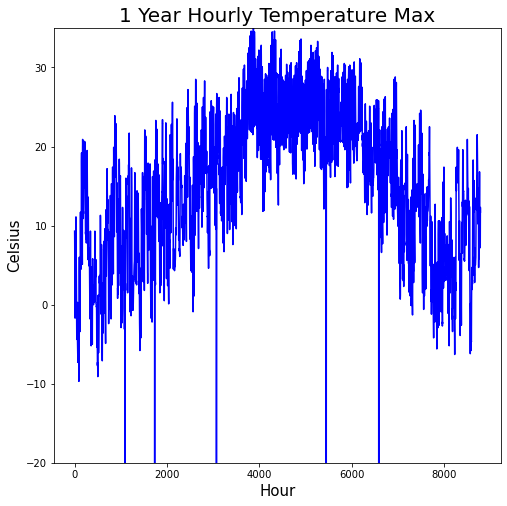

In [8]:
plt.figure(figsize=(8,8))
plt.plot(df_sample['T_MAX'], color='blue')
plt.title('1 Year Hourly Temperature Max', fontsize=20)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Celsius', fontsize=15)
plt.ylim(-20,35)
plt.show()

# Create Lag Variables

In [9]:
conn.dataStep.runCode(code=
    '''
    data durham;
        set durham;
        t_max_1 = lag1(t_max);
        t_max_2 = lag2(t_max);
        t_max_3 = lag3(t_max);
        t_max_4 = lag4(t_max);
        t_max_5 = lag5(t_max);
        
        lst_time_1 = lag1(lst_time);
        lst_time_2 = lag2(lst_time);
        lst_time_3 = lag3(lst_time);
        lst_time_4 = lag4(lst_time);
        lst_time_5 = lag5(lst_time);

        p_calc_1 = lag1(p_calc);
        p_calc_2 = lag2(p_calc);
        p_calc_3 = lag3(p_calc);
        p_calc_4 = lag4(p_calc);
        p_calc_5 = lag5(p_calc);
    run;
    '''
    ,single='YES'
)

conn.table.fetch(table=indata, to=6)

,LST_DATE,LST_TIME,T_MAX,P_CALC,t_max_1,t_max_2,t_max_3,t_max_4,t_max_5,lst_time_1,lst_time_2,lst_time_3,lst_time_4,lst_time_5,p_calc_1,p_calc_2,p_calc_3,p_calc_4,p_calc_5
0,20161231.0,2000.0,7.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20161231.0,2100.0,7.2,0.0,7.3,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,20161231.0,2200.0,6.7,0.0,7.2,7.3,NaN,NaN,NaN,2100.0,2000.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,20161231.0,2300.0,7.0,0.0,6.7,7.2,7.3,NaN,NaN,2200.0,2100.0,2000.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
4,20170101.0,0.0,7.2,0.0,7.0,6.7,7.2,7.3,NaN,2300.0,2200.0,2100.0,2000.0,NaN,0.0,0.0,0.0,0.0,NaN
5,20170101.0,100.0,7.2,0.0,7.2,7.0,6.7,7.2,7.3,0.0,2300.0,2200.0,2100.0,2000.0,0.0,0.0,0.0,0.0,0.0


# Remove Missing Observations

In [10]:
conn.dataStep.runCode(code=
    '''
    data durham missing;
        set durham;
        if cmiss(of _all_) or t_max<-30 then output missing;
        else output durham;
    run;
    '''
)

[InputCasTables]

              casLib    Name   Rows  Columns                                       casTable
 0  CASUSER(student)  durham  87672       19  CASTable('durham', caslib='CASUSER(student)')

[OutputCasTables]

              casLib     Name   Rows  Columns  Append Promoted                                        casTable
 0  CASUSER(student)   durham  87521       19     NaN        N   CASTable('durham', caslib='CASUSER(student)')
 1  CASUSER(student)  missing    151       19     NaN        N  CASTable('missing', caslib='CASUSER(student)')

+ Elapsed: 0.0216s, user: 0.0559s, sys: 0.0278s, mem: 10.8mb

# Partition the Data

In [11]:
conn.dataStep.runCode(code=
    '''
    data train validate test;
        set durham;
        if lst_date < 20150000 then output train;
        else if lst_date < 20170000 then output validate;
        else output test;
    run;
    '''
)

[InputCasTables]

              casLib    Name   Rows  Columns                                       casTable
 0  CASUSER(student)  durham  87521       19  CASTable('durham', caslib='CASUSER(student)')

[OutputCasTables]

              casLib      Name   Rows  Columns  Append Promoted                                         casTable
 0  CASUSER(student)     train  61309       19     NaN        N     CASTable('train', caslib='CASUSER(student)')
 1  CASUSER(student)  validate  17533       19     NaN        N  CASTable('validate', caslib='CASUSER(student)')
 2  CASUSER(student)      test   8679       19     NaN        N      CASTable('test', caslib='CASUSER(student)')

+ Elapsed: 0.0213s, user: 0.0453s, sys: 0.0353s, mem: 11.7mb

# Build the Model

In [12]:
conn.loadActionSet('deepLearn')
actions = conn.builtins.help(actionSet='deepLearn')

NOTE: Added action set 'deepLearn'.
NOTE: Information for action set 'deepLearn':
NOTE:    deepLearn
NOTE:       buildModel - Creates an empty Deep Learning model
NOTE:       addLayer - Adds a layer to a Deep Learning model
NOTE:       removeLayer - Removes a layer from a Deep Learning model
NOTE:       dlPrune - Prunes a layer in a Deep Learning model
NOTE:       modelInfo - Displays model information
NOTE:       dlTune - Tunes hyperparameters for Deep Learning model
NOTE:       dlTrain - Trains a Deep Learning model
NOTE:       dlScore - Scores a table using a Deep Learning model
NOTE:       dlExportModel - Exports a Deep Learning model
NOTE:       dlLabelTarget - Assigns the target label information
NOTE:       dlImportModelWeights - Imports model weights from an external source
NOTE:       dlJoin - Joins the data table and the annotation table


In [13]:
conn.deepLearn.buildModel(
    model = dict(name='lstm', replace=True),
    type = 'RNN'
)

conn.deepLearn.addLayer(
    model = 'lstm',
    layer = dict(type='input', std='std'),
    replace = True,
    name = 'data'
)

conn.deepLearn.addLayer(
    model = 'lstm',
    layer = dict(type='recurrent', n=15, init='xavier', rnnType='LSTM', outputType='samelength'),
    srcLayers = 'data',
    replace = True,
    name = 'rnn1'
)

conn.deepLearn.addLayer(
    model = 'lstm',
    layer = dict(type='recurrent', n=15, init='xavier', rnnType='LSTM', outputType='encoding'),
    srcLayers = 'rnn1',
    replace = True,
    name = 'rnn2'
)

conn.deepLearn.addLayer(
    model = 'lstm',
    layer = dict(type='output', act='identity', init='normal'),
    srcLayers = 'rnn2',
    replace = True,
    name = 'output'
)

conn.deepLearn.modelInfo( 
    model='lstm'
)

,Descr,Value
0,Model Name,lstm
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2


# Create Variables

In [14]:
inputs = ['t_max_5','lst_time_5','p_calc_5',
         't_max_4','lst_time_4','p_calc_4',
         't_max_3','lst_time_3','p_calc_3',
         't_max_2','lst_time_2','p_calc_2',
         't_max_1','lst_time_1','p_calc_1']
target = 'T_MAX'

display(target)
inputs

'T_MAX'

['t_max_5',
 'lst_time_5',
 'p_calc_5',
 't_max_4',
 'lst_time_4',
 'p_calc_4',
 't_max_3',
 'lst_time_3',
 'p_calc_3',
 't_max_2',
 'lst_time_2',
 'p_calc_2',
 't_max_1',
 'lst_time_1',
 'p_calc_1']

# Train the Model

In [15]:
conn.deepLearn.dlTrain(
    table    = 'train',
    validTable = 'validate',
    target = target,
    inputs = inputs,
    sequenceOpts = dict(timeStep=3),
    seed = '1234',
    modelTable = 'lstm',
    modelWeights = dict(name='trained_weights', replace=True),
    optimizer = dict(miniBatchSize=4, maxEpochs=50, 
                     algorithm=dict(method='adam', gamma=0.2, 
                                    learningRate=0.01, clipGradMax=10000, clipGradMin=-10000,stepSize=30, lrPolicy='step'))
)

,Descr,Value
0,Model Name,lstm
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,2985


# Score New Data

In [16]:
conn.deepLearn.dlScore(
    table    = 'test',
    model = 'lstm',
    initWeights = 'trained_weights',
    copyVars = [target]+['LST_DATE','LST_TIME'],
    casout = dict(name='lstm_scored', replace=True)
)

[OutputCasTables]

              casLib         Name  Rows  Columns                                           casTable
 0  CASUSER(student)  lstm_scored  8679        4  CASTable('lstm_scored', caslib='CASUSER(studen...

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          8679
 1  Number of Observations Used          8679
 2           Mean Squared Error      0.797994
 3                   Loss Error      0.398997

+ Elapsed: 0.0547s, user: 0.137s, sys: 0.028s, mem: 20.3mb

# Analyze Results Locally

In [17]:
# Bring data to the client
df = conn.CASTable(name='lstm_scored')
df = df.to_frame()

# Order data by date and time
df.sort_values(['LST_DATE','LST_TIME'],inplace=True, ascending=True)
display(df.head())
df.shape

,T_MAX,LST_DATE,LST_TIME,_DL_Pred_
1724,7.2,20170101.0,100.0,7.281178
1725,7.2,20170101.0,200.0,7.034275
1726,7.3,20170101.0,300.0,7.176041
1727,7.4,20170101.0,400.0,7.234590
1728,7.5,20170101.0,500.0,7.109282


(8679, 4)

In [18]:
print('Average absolute error = ' + str(round(abs(df['T_MAX']- df['_DL_Pred_']).mean(),4)))

Average absolute error = 0.5628


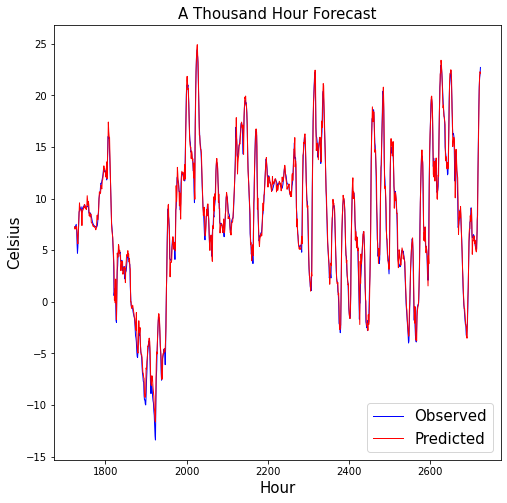

In [19]:
# Forecast 1000 hours
plt.figure(figsize=(8,8))
plt.plot(df['T_MAX'][:1000], color='blue', linewidth=1, label='Observed')
plt.plot(df['_DL_Pred_'][:1000], color='red', linewidth=1, label='Predicted')
plt.title('A Thousand Hour Forecast', fontsize=15)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Celsius', fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.show()

# End the Session

In [20]:
conn.session.endSession()

+ Elapsed: 0.000181s, user: 0.000152s, sys: 1.9e-05s, mem: 0.209mb